For the differential equation:
$$EI \dfrac{d^2 y}{dx^2} = \dfrac{wLx}{2} - \dfrac{wx^2}{2}$$

Where the following parameters are described as (with some sensible starting values in brackets):
 * $E$ is the modulus of elasticity ($150$ GPa),
 * $I$ is the moment of inertia ($20000$ cm$^4$),
 * $w$ is the applied load ($10$ kN/m),
 * $L$ is the length of the beam ($10$ m).

I will solve this using finite differences, whilst calculating an analytical solution for comparisson.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#setting parameters and converting units
E = 150e9 #Pa
I = 2e-4 #m^4
omega = 10e3 #N/m
L = 10 #m

The analytical system found through seperation of variables and using B.C. that at $x=0, y=0$ and at $x=L, y=0$ as the beam is supported at both ends.
$$ y = \frac{x\omega}{12EI}(Lx^{2}-\frac{x^{3}}{2}-\frac{L^{3}}{2})$$

In [5]:
def analytical_sol(x):
    y1 = (x*omega)/(12*E*I)
    y2 = (L*x**2) - ((x**3)/2)-((L**3)/2)
    return (y1*y2)


The finite differences schemes given in lectures are the forward and backward solver. These have basic second order expansions with errors of order $O(h)$. However the centered difference approximation is more relevant to this problem due to its symmetry. I shall make a comparisson of the central difference scheme with an error of order $O(h^{2})$ to a more accurate central difference scheme with a higher order of error, $O(h^{4})$.

Central difference second order approximation with error of order $O(h^{2})$:

$$f''(x) \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^{2}} + O(h^{2})$$

Central difference second order approximation with error of order $O(h^{4})$:

$$f''(x) = \frac{-f(x + 2h) + 16f(x + h) - 30f(x) + 16f(x - h) - f(x - 2h)}{12h^{2}}$$


By subbing these into the given DE we get that:

for Central Difference $O(h^{2})$: 
$$y_{i+1} - 2y_{i} + y_{i-1}= \frac{h^{2}}{EI}[\frac{\omega L x_{i}}{2} - \frac{\omega x_{i}^{2}}{2}] $$

for order $O(h^{4})$:
$$-y_{i+2} + 16y_{i+1} - 30y_{i} + 16y_{i-1} - y_{i-2}= \frac{6h^{2}}{EI}[\omega L x_{i} - \omega x_{i}^{2}]$$

To solve these systems we create matrix forms to efficently solve the set of simulataneous equations.

$$\begin{bmatrix} 1 & 0 & 0 & 0 &\cdots & 0 \\1 & -2 & 1 & 0 & \cdots & 0 \\0 & 1 & -2 & 1 & \cdots & 0 \\ \vdots & \vdots & \ddots & \ddots & \ddots & 0 \\ 0 & 0 & \cdots & 1 & -2 & 1 \\ 0 & 0 & 0 & 0 & \cdots & 1 \\ \end{bmatrix} \begin{bmatrix} y_{0} \\ y_{1} \\ y_{2} \\ \vdots \\ y_{n-1} \\ y_{n} \end{bmatrix} = \begin{bmatrix} 0 \\ f(x_{1}) \\ f(x_{2} \\ \vdots \\ f(x_{n-1}) \\ 0 \end{bmatrix}$$

where $f(x_{i}) = \frac{h^{2}}{EI}[\frac{\omega L x_{i}}{2} - \frac{\omega x_{i}^{2}}{2}] $, and we have imposed the boundary conditions that at x = 0, and L, y = 0.

The corresponding form for the more accurate method is:
$$\begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\ \frac{15}{4} & -\frac{77}{6} & \frac{107}{6} & -13 & \frac{61}{12} & -\frac{5}{6} & \cdots & 0 \\ -1 & 16 & -30 & 16 & -1 & 0 & \cdots & 0 \\0 & -1 & 16 & -30 & 16 & -1 & \cdots & 0 \\0 & 0 & -1 & 16 & -30 & 16 & \ddots & 0 \\ \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & -1\\ 0 & \cdots & -\frac{5}{6} & \frac{61}{12} & -13 & \frac{107}{6} & -\frac{77}{6} & \frac{15}{4} \\ 0 & 0 & 0 & 0 & 0 & 0 & \cdots & 1 \\ \end{bmatrix} \begin{bmatrix} y_{0} \\ y_{1} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ y_{n-1} \\ y_{n} \end{bmatrix} = \begin{bmatrix} 0 \\ f(x_{1}) \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ f(x_{n-1}) \\ 0 \end{bmatrix}$$

where $f(x_{i}) = \frac{6h^{2}}{EI}[\omega L x_{i} - \omega x_{i}^{2}] $, and we have imposed the boundary conditions that at x = 0, and L, y = 0 and I have used the second order forward and backward schemes with an error of order $O(h^{4})$ for the 2nd and 2nd last row respectively. These are given by:
$$f''(x) \approx \frac{\frac{15}{4}f(x) − \frac{77}{6}f(x \pm h) + \frac{107}{6}f(x \pm 2h) − 13f(x \pm 3h) + \frac{61}{12}f(x \pm 4h) - \frac{5}{6}f(x \pm 5h)}{h^{3}} + O(h^{4})$$
for the forward and backward schemes respectively as given by the finite differences coefficients wikipedia page.


I shall implement a central difference scheme with the option to use the increased accuracy method if desired.

In [6]:

def central_diff(num_steps, increased_accuracy):
    '''
    funtion that takes in the number of steps and the increased accuracy boolean and returns the solved matrix equation using
    the central difference approximation.
    If the increased_accuracy boolean is true then the O(h^4) difference scheme is used.
    '''
    h = L/(num_steps-1) #step size
    x = np.linspace(0, L, num_steps)

    #initialising arrays/matrix
    y_array = np.zeros(shape = (num_steps,1))
    indices_matrix = np.zeros(shape = (num_steps, num_steps))
    
    #for higher order central difference matrix
    if increased_accuracy:
        assert num_steps >= 6 #needs to have at least more than 6 steps to be worth doing/succesful as there are 6 specified 
        #coefficients in the forward/backward 4th order scheme
        
        #setting func(x) array for the central components
        for i in range(2, num_steps-1):
            y_array[i] = ((6*omega*h**2)/(E*I))*(L*i*h-(i*h)**2) 
            
        #setting second and second last components of func(x) array, different scheme so different constants here
        #y[0] and y[-1] are kept as zero
        y_array[1] = ((omega*h**3)/(2*E*I))*(L*h-h**2) 
        y_array[-2] = ((omega*h**3)/(2*E*I))*(L*(num_steps-2)*h-((num_steps-2)*h)**2) 

        
        #setting central indices of the matrix for second order central difference with 4th order accuracy
        for i in range(2, num_steps-2):
            indices_matrix[i][i] = -30
            indices_matrix[i][i-1] = 16
            indices_matrix[i][i+1] = 16
            indices_matrix[i][i+2] = -1
            indices_matrix[i][i-2] = -1
        
        #manually setting boundary conditions as well as forward/backward coefficients for first 2 and last 2 rows
        indices_matrix[0][0] = 1
        indices_matrix[1][0] = 15/4
        indices_matrix[1][1] = -77/6
        indices_matrix[1][2] = 107/6
        indices_matrix[1][3] = -13
        indices_matrix[1][4] = 61/12
        indices_matrix[1][5] = -5/6
        indices_matrix[num_steps-1][num_steps-1] = 1
        indices_matrix[num_steps-2][num_steps-1] = 15/4
        indices_matrix[num_steps-2][num_steps-2] = -77/6
        indices_matrix[num_steps-2][num_steps-3] = 107/6
        indices_matrix[num_steps-2][num_steps-4] = -13
        indices_matrix[num_steps-2][num_steps-5] = 61/12
        indices_matrix[num_steps-2][num_steps-6] = -5/6
        
    else:
        #for lower order central difference method
        assert num_steps > 3
        
        #setting the f(x) array, first and last elemnt are both zero 
        for i in range(0, num_steps):
            y_array[i] = ((omega*(h**2))/(2*E*I))*(L*i*h-(i*h)**2) 
            
        #central difference indice matrix for 2nd order accuracy
        for i in range(1, num_steps-1):
            indices_matrix[i][i] = -2
            indices_matrix[i][i-1] = 1
            indices_matrix[i][i+1] = 1
        #seeting end elements for boundary conditions
        indices_matrix[0][0] = 1
        indices_matrix[num_steps-1][num_steps-1] = 1
    
    #returns solutions for whichever method is required
    return np.linalg.solve(indices_matrix, y_array), x


We can plot the results using a variety of step sizes to see the optimal course of action.

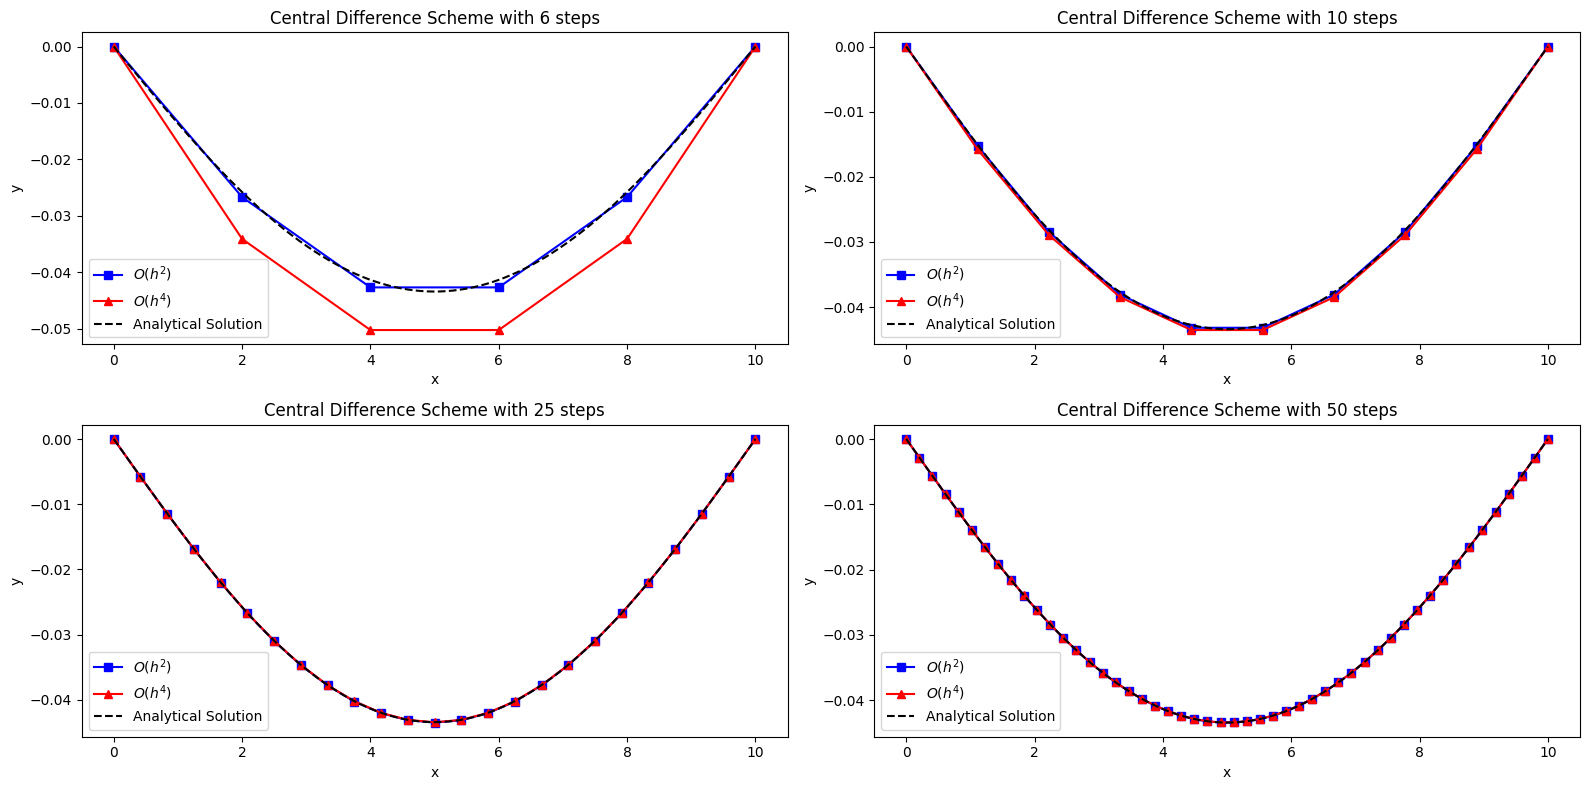

In [8]:
num_steps = [6, 10, 25, 50]


max_n = 1000
x = np.linspace(0, L, max_n)

fig1, axes = plt.subplots(2, 2, figsize=(16, 8))

#setting indices for easy plot location manipulation
i = 0
j = 0
#iterating over different numbers of steps
for n in num_steps:
    #storing schemes of both accuracies in tempory variables
    central_diff_y, x1 = central_diff(n, increased_accuracy = False)
    better_central_diff_y, x2 = central_diff(n, increased_accuracy = True)

    #plotting the temporary variables
    axes[i, j].plot(x1, central_diff_y, color = 'blue', label = '$O(h^{2})$', marker = 's')
    axes[i, j].plot(x2, better_central_diff_y, color = 'red', label = '$O(h^{4})$', marker = '^')
    axes[i, j].plot(x, analytical_sol(x), '--', color = 'black', label = 'Analytical Solution')
    axes[i, j].set_title(f"Central Difference Scheme with {n} steps")
    axes[i, j].set_xlabel('x')
    axes[i, j].set_ylabel('y')
    axes[i, j].legend()
    
    #plot location manipulation
    j +=1 
    if j == 2:
        i = 1
        j = 0

fig1.tight_layout()
plt.show()

From the above plots the appropriate step size can be chosen, you can also compare the errors by plotting the residuals at each point against the step size chosen.